# Objekterkennung mit YOLOv4
Objekterkennung ist eine der wichtigsten Aufgabe von Computer Vision. Wie der Name bereits vermuten lässt, ist das wesentliche Ziel Objekte von Interesse in einem Bild oder einer Folge von Bildern zu erkennen. Das können etwa Personen und Fahrzeuge, oder aber auch verschiedene Elemente in Abbildungen sein (z.B. Texte in Grafiken). Zur Objekterkennung gibt es verschiedene Methoden, darunter Frame Differencing und YOLO. Letzteres steht dabei für *You only look once* und steht für ein Object-Detection-Framework, das vielseitig einsetzbar ist und dem Nutzenden eine einfache Schnittstelle zur Nutzung zur Verfügung stellt. Dieses Notebook stellt beispielhaft vor, wie ein vortrainiertes YOLO-Modell zur Erkennung von Objekten in Bildern verwendet werden kann. Die Umsetzung erfolgt dabei als Klasse in Python, die auf vortrainierte Gewichte zugreift und eine Methode zur Nutzung des Modells anbietet.

## Pakete importieren
Im Wesentlichen wird für die Umsetzung lediglich **Open-CV** benötigt. Dabei handelt es sich um eine Open-Source Computer Vision Bibliothek, die ein breites Spektrum an Methoden zur Arbeit mit Bildern und CNN-Netzwerken im Bildkontext zur Verfügung stellt. Die Bilder werden intern als NumPy-Arrays gespeichert und können mit der Matplotlib Bibliothek dargestellt werden.

In [1]:
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List

## Config Dateien festlegen
Wie bereits genannt, kann Open-CV auf vortrainierte YOLO-Modelle zugreifen und diese nutzen. Um ein Modell laden zu können, werden daher sowohl die reinen Gewichte als auch eine Config-Datei benötigt, die die Architektur des Netzwerkes enthält und zur Zuordnung der Gewichte benötigt wird.
Das in diesem Projekt verwendete YOLO-Modell wurde auf dem COCO-Datensatz vortrainiert und kann dementsprechend die darin enthaltenen Klassen bzw. Objekte erkennen. Um im weiteren Verlauf auch den Namen einer Klasse und nicht nur deren Nummer zu kennen, werden zusätzlich die Klassenbezeichnungen des COCO-Datensatzes benötigt. Alle drei Dateien können an einem beliebigen Speicherort gesichert werden und anschließend über den entsprechenden Dateipfad genutzt werden.

### Download der YOLO-Dateien
YOLOv4 stellt zwei Varianten für den COCO-Datensatz zur Verfügung, die sich in der Größe des Netzwerkes unterscheiden. Das kleinere Netzwerk hat eine geringere Genauigkeit in der Erkennung, verwendet jedoch weniger Rechenleistung und schafft damit mehr FPS.

**YOLOv4**
- Weights-File: https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights
- Config-File: https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4.cfg

**YOLOv4-Tiny**
- Weights-File: https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights
- Config-File: https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4-tiny.cfg

In [2]:
WEIGHTS_PATH = Path('YOLO/yolov4-tiny.weights')
CONFIG_PATH = Path('YOLO/yolov4-tiny.cfg')
LABEL_PATH = Path('YOLO/coco-labels.txt')

FILTER = ['person']

## Klasse zur Objekterkennung
Nachfolgend wird eine Klasse definiert, die ein YOLO-Modell lädt und es zur Objekterkennung nutzt. Beim Initialisieren müssen daher die Pfade zu den drei Config Dateien angegeben werden. Anschließend kann das Netzwerk mit Open-CV geladen und in ein Detection Modell umgewandelt werden. Zusätzlich werden die Klassenbezeichnungen geladen und als Instanz Variable gespeichert. Die Klasse bietet ebenfalls die Möglichkeit, die erkannten Objekte nach ihrer Klasse zu filtern. Dazu kann beim Initialisieren eine Liste an Klassennamen als Parameter angegeben werden, die bei der Erkennung zum Filtern genutzt wird. Um den Filter zu *aktivieren*, muss beim Aufruf der *detect_objects* Methode der Parameter *apply_filter* auf True gesetzt werden.

**Beispiel: Filter zur Fahrzeugerkennung**
```
# Create detection class
vehicle_detector = YoloDetector(WEIGHTS_PATH, CONFIG_PATH, LABEL_PATH, ['car', 'bus', 'truck', 'motorcycle'])
# Use instance Method to detect objects in frame
classes, scores, boxes = vehicle_detector.detect_objects(frame, True)
```

Die Rückgabewerte der *detect_objects* Methode geben die Klassen-ID (nicht den Klassennamen), den Vorhersage Score des Modells sowie die Bounding Boxes im Bild an. Alle drei werden als NumPy-Array zurückgegeben und haben die gleiche Anzahl an Elementen.

In [3]:
class YoloDetector:
    CONFIDENCE_THRESHOLD = 0.7
    NMS_THRESHOLD = 0.4

    def __init__(self, weights_path: Path, config_path: Path, label_path: Path, detection_filter: List[str] = None):
        net = cv2.dnn.readNet(weights_path.__str__(), config_path.__str__())
        net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
        self.model = cv2.dnn_DetectionModel(net)
        self.model.setInputParams(size=(416, 416), scale=1 / 255, swapRB=True)
        with open(label_path, 'r') as f:
            self.class_names = [cname.strip() for cname in f.readlines()]
        self.filter = detection_filter

    def detect_objects(self, frame: np.ndarray, apply_filter: bool = True) -> \
            Tuple[np.ndarray, np.ndarray, np.ndarray]:
        # Use model to get all objects
        classes, scores, boxes = self.model.detect(frame, YoloDetector.CONFIDENCE_THRESHOLD, YoloDetector.NMS_THRESHOLD)
        # If required filter out all non vehicle objects
        if apply_filter and self.filter is not None:
            classes, scores, boxes = self.filter_detections(classes=classes, scores=scores, boxes=boxes)
        # Return bounding boxes, scores and predicted classes
        return classes, scores, boxes

    def filter_detections(self, classes, scores, boxes) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        indices = [i for i, c in enumerate(classes) if self.class_names[c] in self.filter]
        return np.array(classes)[indices], np.array(scores)[indices], np.array(boxes)[indices]

## Weitere Methoden
Um die Funktionsweise der Klasse einfach zeigen zu können, werden nachfolgend zwei weitere Methoden definiert:

1. **display_image():** Diese Methode nimmt ein Bild als NumPy-Array als Input und stellt es mithilfe von Matplotlib dar. Wichtig ist dabei zu beachten, dass Open-CV die Bilder im BGR-Format abspeichert und die Bilder vor der Darstellung konvertiert werden müssen - sonst gibt es falsche Farben.
2. **show_detections():** Die zweite Methode kann genutzt werden, um gefundene Objekte auf einem Bild zu markieren bzw. zu zeigen. Für jedes Objekt wird die Bounding Box gezeichnet und mit einem Text zu Klassenname und Vorhersage Score versehen.

In [4]:
def display_image(img: np.ndarray, title: str = '', figsize: Tuple[int, int] = (10, 6)):
    fig, axs = plt.subplots(figsize=figsize)
    fig.suptitle(title, fontsize=16)
    axs.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    plt.show()


def show_detections(frame: np.ndarray, classes: np.ndarray, scores: np.ndarray, boxes: np.ndarray) -> np.ndarray:
    for (classid, score, box) in zip(classes, scores, boxes):
        color = (0, 0, 255)
        label = '%s : %f' % (detector.class_names[classid], score)
        cv2.rectangle(frame, box, color, 2)
        centroid_x, centroid_y = box[0] + int(box[2] / 2), box[1] + int(box[3] / 2)
        cv2.circle(frame, (centroid_x, centroid_y), radius=0, color=(0, 0, 255), thickness=5)
        cv2.putText(frame, label, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
    return frame

## Nutzung der Klasse
Nachdem die Klasse an sich und die beiden Methoden definiert wurden, können diese natürlich auch genutzt werden. Daher wird im ersten Schritt zunächst ein Bild geladen, das in diesem Fall im gleichen Ordner wie das Notebook abliegt (Pfad kann natürlich entsprechend angepasst werden). Mit der vorher definierten Methoden kann das Bild anschließend angezeigt werden.

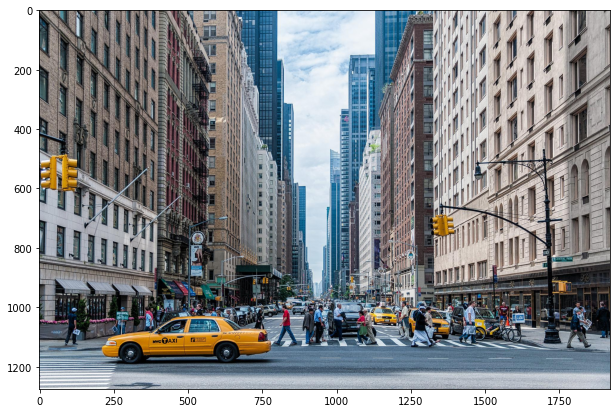

In [5]:
image = cv2.imread('NewYork.jpg')
display_image(image)

Im zweiten Schritt wird eine Instanz der Klasse angelegt und zur Objekterkennung verwendet. Dazu werden die oben definierten Config Pfade sowie der Objektfilter genutzt (der lediglich die Klasse Person enthält).

In [6]:
detector = YoloDetector(weights_path=WEIGHTS_PATH, config_path=CONFIG_PATH, label_path=LABEL_PATH, detection_filter=FILTER)
classes, scores, boxes = detector.detect_objects(frame=image, apply_filter=False)

Die Klassen werden als Zahlen ausgegeben und können über das Attribut `detector.class_names` in Namen umgewandelt werden.

In [7]:
print(classes)

[0 0 0 0 0 2 9]


Die Scores geben an, mit welcher Wahrscheinlichkeit das erkannte Objekt zu der ermittelten Klasse gehört. Über den Parameter *CONFIDENCE_THRESHOLD* kann festgelegt werden, welche untere Grenze zur Erkennung verwendet werden soll.

In [8]:
print(scores)

[0.942965   0.82585216 0.8012027  0.751495   0.7049699  0.9901994
 0.70193386]


Jede Bounding Box ist durch vier Zahlen definiert und spiegelt den Bereich im Bild wider, in dem sich ein bestimmtes Objekt befindet.

In [9]:
print(boxes)

[[ 891  988   56  143]
 [ 797  982   71  154]
 [1779  983   76  151]
 [1240  993   86  133]
 [1404  979   82  143]
 [ 208 1035  575  159]
 [   0  485   84  129]]


Die erkannten Objekte können auf dem Bild eingezeichnet und anschließend erneut dargestellt werden. In diesem Fall wurde der Filter nicht aktiviert, daher sind alle Objekttypen zu finden.

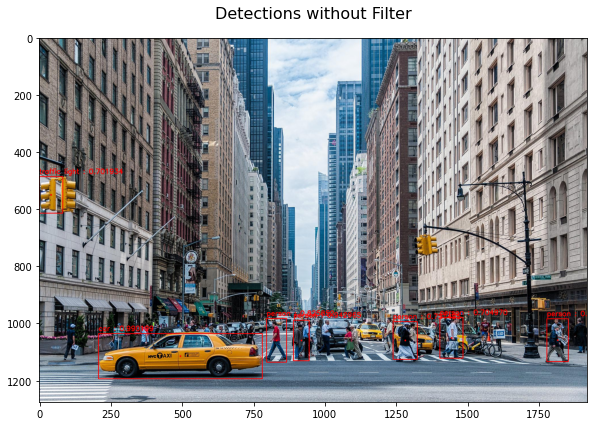

In [10]:
detections_image = show_detections(frame=image.copy(), classes=classes, scores=scores, boxes=boxes)
display_image(img=detections_image, title='Detections without Filter')

Wenn der Filter aktiviert wird, werden alle irrelevanten Klassen aussortiert und nicht weiter betrachtet.

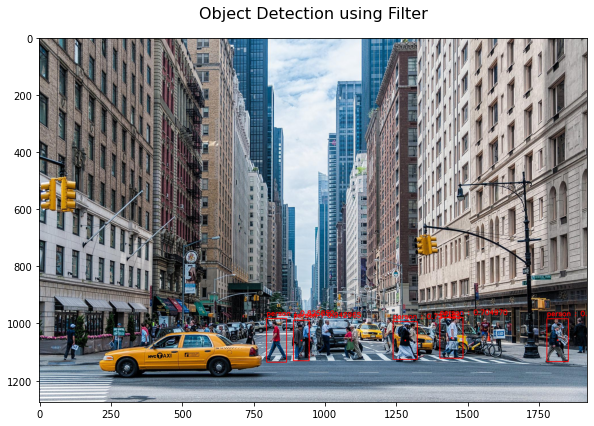

In [11]:
classes, scores, boxes = detector.detect_objects(frame=image, apply_filter=True)
detections_image = show_detections(frame=image.copy(), classes=classes, scores=scores, boxes=boxes)
display_image(img=detections_image, title='Object Detection using Filter')

## Echtzeiterkennung
Um die bisher vorgestellten Inhalte in Action zu sehen, greift der nachfolgende Codeblock auf die Kamera zu (soweit vorhanden) und erkennt in Echtzeit Objekte. Je nach Rechenleistung des Geräts kann die Anzahl der Frames pro Sekunde variieren, daher kann das Video eventuell haken oder nicht flüssig erscheinen. Um die Echtzeiterkennung zu beenden, muss die Ausführung der Zelle manuell gestoppt oder in der Anzeige des Videos mit **Esc** beendet werden. Die Nutzung der Kamera wird daraufhin wieder beendet und das Anzeigefenster geschlossen.

In [12]:
# Create video capture item (0 activates the webcam)
capture = cv2.VideoCapture(0)

# Start reading frames and use YOLO to detect objects
try:
    ret, frame = capture.read()
    while ret:
        classes, scores, boxes = detector.detect_objects(frame=frame, apply_filter=False)
        frame = show_detections(frame, classes, scores, boxes)
        cv2.imshow('video', frame)

        key = cv2.waitKey(1)
        if key == 27:
            break
        ret, frame = capture.read()
except KeyboardInterrupt:
    pass
# Release resources once done
finally:
    print('Stopping Detections, Resources will be released.')
    capture.release()
    cv2.destroyAllWindows()

Stopping Detections, Resources will be released.
